In [56]:
import numpy as np
import random
from collections import defaultdict, deque
import matplotlib.pyplot as plt



In [58]:
class MazeEnv:
    def __init__(self, size=100, obstacle_count=100):
        self.size = size
        self.maze = np.zeros((size, size), dtype=int)
        self.start = None
        self.goal = None
        self.obstacle_count = obstacle_count
        self._generate_obstacles()
        self._set_start_and_goal()

    def _generate_obstacles(self):
        count = 0
        while count < self.obstacle_count:
            x, y = random.randint(0, self.size - 1), random.randint(0, self.size - 1)
            if (x, y) != (0, 0) and (x, y) != (self.size - 1, self.size - 1) and self.maze[x, y] == 0:
                self.maze[x, y] = 1
                if not self._path_exists():
                    self.maze[x, y] = 0
                else:
                    count += 1

    def _path_exists(self):
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        start = (0, 0)
        goal = (self.size - 1, self.size - 1)
        visited = set()
        queue = deque([start])

        while queue:
            x, y = queue.popleft()
            if (x, y) == goal:
                return True
            for dx, dy in directions:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size and self.maze[nx, ny] == 0 and (nx, ny) not in visited:
                    visited.add((nx, ny))
                    queue.append((nx, ny))
        return False

    def _set_start_and_goal(self):
        free_cells = [(i, j) for i in range(self.size) for j in range(self.size) if self.maze[i, j] == 0]
        self.start = random.choice(free_cells)
        free_cells.remove(self.start)
        self.goal = random.choice(free_cells)
        self.maze[self.start] = -1
        self.maze[self.goal] = -2



In [60]:
class RLAgent:
    def __init__(self, env, discount_factor=0.99, learning_rate=0.1, exploration_rate=0.1):
        self.env = env
        self.actions = ['up', 'down', 'left', 'right']
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate
        self.exploration_rate = exploration_rate
        self.q_values = defaultdict(lambda: defaultdict(float))
        self.rewards = self._init_rewards()

    def _init_rewards(self):
        rewards = {}
        for i in range(self.env.size):
            for j in range(self.env.size):
                state = (i, j)
                if state == self.env.goal:
                    rewards[state] = 100
                else:
                    rewards[state] = -1
        return rewards

    def _next_state(self, state, action):
        i, j = state
        if action == 'up':
            i -= 1
        elif action == 'down':
            i += 1
        elif action == 'left':
            j -= 1
        elif action == 'right':
            j += 1

        if 0 <= i < self.env.size and 0 <= j < self.env.size and self.env.maze[i, j] != 1:
            return (i, j)
        else:
            return state

    def choose_action(self, state):
        q_values = self.q_values[state]

        if not q_values:
            for action in self.actions:
                q_values[action] = 0

        max_q = max(q_values.values(), default=0)
        best_actions = [action for action, q in q_values.items() if q == max_q]

    
        if not best_actions:
            return random.choice(self.actions)

        return random.choice(best_actions)

    def train(self, num_episodes=1000, max_steps=100):
        for episode in range(num_episodes):
            state = self.env.start
            step_count = 0

            while state != self.env.goal and step_count < max_steps:
                action = self.choose_action(state)
                next_state = self._next_state(state, action)
                reward = self.rewards[next_state]

                max_future_q = max(self.q_values[next_state].values(), default=0)
                td_target = reward + self.discount_factor * max_future_q
                td_delta = td_target - self.q_values[state][action]
                self.q_values[state][action] += self.learning_rate * td_delta

                state = next_state
                step_count += 1

            self.exploration_rate = max(0.01, self.exploration_rate * 0.995)

            if (episode + 1) % 100 == 0:
                print(f"Episode {episode + 1}/{num_episodes} completed.")

            if state == self.env.goal:
                print(f"Goal reached in episode {episode + 1} after {step_count} steps.")



In [62]:
def plot_policy(agent):
    maze = np.copy(agent.env.maze)
    plt.figure(figsize=(12, 12))  
    for state in agent.env.start, agent.env.goal:
        i, j = state
        if state == agent.env.start:
            color = 'green'
        else:
            color = 'red'
        plt.scatter(j, i, c=color, s=100)

    for state in agent.rewards:
        i, j = state
        if agent.env.maze[i, j] == 0:
            action = agent.choose_action(state)
            dx, dy = 0, 0
            if action == 'up':
                dx, dy = 0, -0.5
            elif action == 'down':
                dx, dy = 0, 0.5
            elif action == 'left':
                dx, dy = -0.5, 0
            elif action == 'right':
                dx, dy = 0.5, 0
            plt.arrow(j, i, dx, dy, head_width=0.2, head_length=0.2, fc='orange', ec='orange')

    plt.imshow(maze, cmap='gray_r')
    plt.title('Policy Visualization', fontsize=16)
    plt.grid(True)
    plt.xticks(np.arange(0, agent.env.size, step=10))
    plt.yticks(np.arange(0, agent.env.size, step=10))
    plt.show()



In [64]:
# Initialize the environment and agent
environment = MazeEnv()
agent = RLAgent(environment)
agent.train(num_episodes=1000)



Episode 100/1000 completed.
Episode 200/1000 completed.
Episode 300/1000 completed.
Episode 400/1000 completed.
Episode 500/1000 completed.
Episode 600/1000 completed.
Episode 700/1000 completed.
Episode 800/1000 completed.
Episode 900/1000 completed.
Episode 1000/1000 completed.


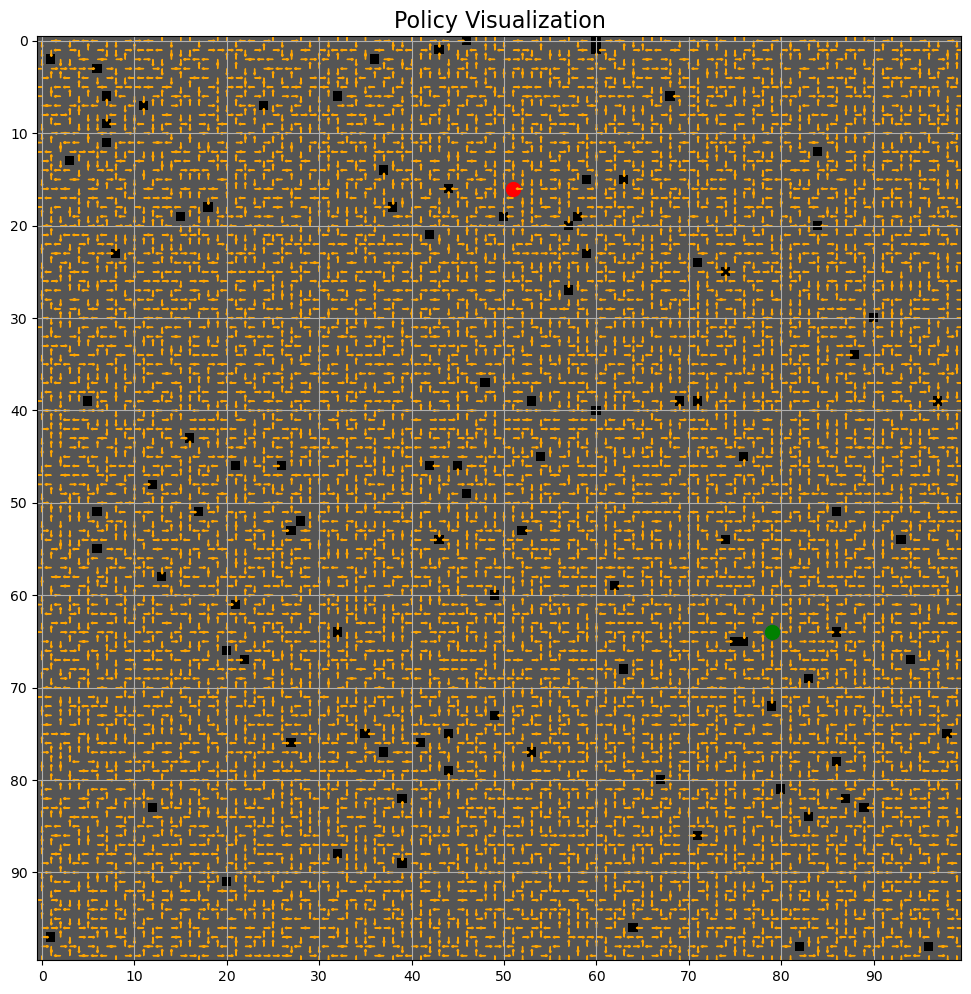

In [65]:
# Visualize the policy
plot_policy(agent)
